In [1]:
import pandas as pd
import numpy as np
import pickle
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

# Phase 1: Data

In [2]:
#plots
BINS = 50

COLORS = {
    "Liu Yu": "#2ca02c",
    "Mika":"#1f77b4",
}

In [3]:
# Load
tweet_ids, tweets = pickle.load( open('tweets_and_tweetids.p', "rb" ) )
df = pd.DataFrame(tweets)

# -----  Data Preprocessing -----
# get unique tweet users
nodes, ct = np.unique(df["username"],return_counts=True)

# get mentioned users in all tweets
df["mentioned"] = df['content'].str.findall(r'@([\w]+)')

# get unique mentioned users (authors)
m_nodes = np.unique(np.concatenate(df["mentioned"]))

# create map from username to id
node_map = {}
for i, n in enumerate(np.concatenate((nodes, m_nodes))):
    node_map[n] = i
node_map_inv = {v: k for k, v in node_map.items()}

# map username to id
df["node"] = df["username"].map(node_map)
df = df.assign(m_node=[[node_map[k] for k in row if node_map.get(k)] for row in df.mentioned])
    
num_liuyu = len(df[df['Liu Yu']])
num_mika = len(df[df['Mika']])

# datetime
df['date'] = pd.to_datetime(df['date'], utc=True)
df = df[df["date"]<"2021-04-25"]

df = df.drop(['userid','retweet_original_username', 'retweet_original_userid' ], axis=1)

# ------- Data Summary ------
print(f"Number of tweets: {len(tweet_ids):,}", ) # 137098
temp = len(df[df["content"].str.startswith("RT @")])
print(f"\nNumber of retweets: {temp:,}  [{temp/len(df):.0%}] ")
print(f"Number of original tweets: {len(df) - temp:,}  [{1- (temp/len(df)):.0%}] ")

print(f"\nNumber of Liu Yu's tweets = {num_liuyu:,}  [{num_liuyu/len(df):.0%}]"  )
print(f"Number of  Mika's tweets = {num_mika:,}  [{num_mika/len(df):.0%}]",  )

print(f"\nNumber of users (nodes): {len(nodes):,}",)
print(f"Number of author users: {len(m_nodes):,}")
temp = [i for i in m_nodes if i in nodes]
print(f"Number of author users in nodes: {len(temp)} [{len(temp)/len(m_nodes):.0%}]")
print(f"\nTweet date from: {df['date'].min()} to {df['date'].max()}" ) # 2021-04-05 
      
df.tail()

Number of tweets: 505,814

Number of retweets: 460,732  [93%] 
Number of original tweets: 35,391  [7%] 

Number of Liu Yu's tweets = 190,015  [38%]
Number of  Mika's tweets = 370,153  [75%]

Number of users (nodes): 53,413
Number of author users: 4,024
Number of author users in nodes: 3380 [84%]

Tweet date from: 2021-02-17 00:25:23+00:00 to 2021-04-24 23:59:58+00:00


,id,date,content,username,keyword,Liu Yu,Mika,mentioned,node,m_node
505062,1384412041088159744,2021-04-20 07:42:06+00:00,RT @caelanschedule: 4. Who is the king of snac...,baitoeii3,mika chuang,False,True,[caelanschedule],23342,[55094]
505063,1368522941076439041,2021-03-07 11:24:29+00:00,"Mika ""So Sick"" | 创造营 CHUANG 2021 Clip EP01 | W...",In_MyHae,mika chuang,False,True,[YouTube],7311,[54736]
505150,1385997435248414724,2021-04-24 16:41:53+00:00,RT @Aly_maie: Kazuma IG Post\n\n#Mika #米卡 #INT...,baitoeii3,米卡 #CHUANG2021,False,True,[Aly_maie],23342,[53545]
505151,1385974685540569089,2021-04-24 15:11:29+00:00,RT @CHUANG_Official: #Chuang2021TheFinal \n\nC...,eunseozg,米卡 #CHUANG2021,False,True,[CHUANG_Official],27542,[53677]
505152,1385969672533598208,2021-04-24 14:51:34+00:00,RT @Bom17001618: กูยังไม่โอเคร😭\n#Mika #Caelan...,baitoeii3,米卡 #CHUANG2021,False,True,[Bom17001618],23342,[53650]


In [4]:
# # list(df.loc[(df["Liu Yu"]) & (df["content"].str.contains("宇")), "content"].sample(10))
# df.loc[355080, "content"]

In [5]:
# temp = df.sample(10)
# temp["id"] = temp["id"].astype(str).str[0:5]+"-"*5
# temp["username"] = temp["username"].astype(str).str[0:5]+"-"*5
# temp

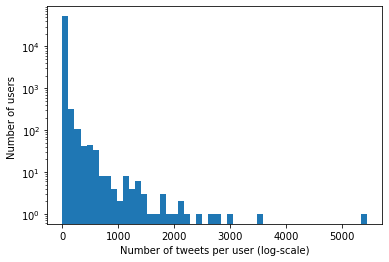

In [6]:
_ = plt.hist(ct,log=True, bins=BINS) 
_ = plt.xlabel("Number of tweets per user (log-scale)")
_ = plt.ylabel("Number of users ")

# 2. Topology analysis
## 2.1 Overall

In [7]:
import networkx as nx
import collections
import time

In [8]:
adj = df[["node", "m_node", "Liu Yu", "Mika"]]
adj = pd.DataFrame({ col:np.repeat(adj[col].values, df["m_node"].str.len())
              for col in adj.columns.drop("m_node")}
            ).assign(**{"m_node":np.concatenate(df["m_node"].values).astype(int)})
adj.to_csv("adj.csv", index=False)

In [9]:
temp = adj.copy()
temp["node"] = temp["node"].map(node_map_inv)
temp["m_node"] = temp["m_node"].map(node_map_inv)
for group in ["Liu Yu", "Mika"]:
    temp.loc[temp[group],["node", "m_node"]].to_csv(f"adj_{group}.csv", index=False)

## 2.2 Top degree nodes

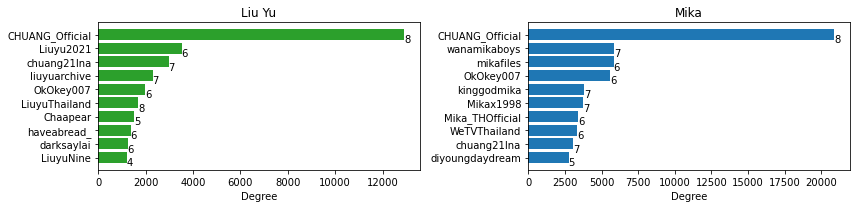

In [10]:
plt.figure(figsize=(12,3))
for i_, group in enumerate(["Liu Yu", "Mika"]):
    plt.subplot(1,2,i_+1)
    links = adj[adj[group]].drop(group,axis=1).drop_duplicates(ignore_index=True)
    G = nx.from_pandas_edgelist(links, source="m_node", target="node", create_using=nx.DiGraph)
    temp = sorted(G.out_degree(), key=lambda x: x[1], reverse=True)
    temp = temp[:10]
    temp2 = []
    for i, ( max_node, max_degree ) in enumerate(temp):
        temp2.append([node_map_inv[temp[i][0]],int(temp[i][1])])
    temp2 = np.array(temp2)[::-1]

    plt.barh(temp2[:,0], temp2[:,1].astype(int), color=COLORS[group])
    for i in range(len(temp)):
        l = max(nx.shortest_path_length(G, source=temp[i][0]).values())
        plt.annotate(l, xy=(int(temp2[i,1]), temp2[i,0]), ha='left', va='top')
    _ = plt.xlabel('Degree')
    _ = plt.title(group)
plt.tight_layout()
plt.savefig(f"./fig/top_nodes.png")

mentioned --> user
## 2.3 Statistics

/opt/conda/envs/rapids/lib/python3.7/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if __name__ == '__main__':


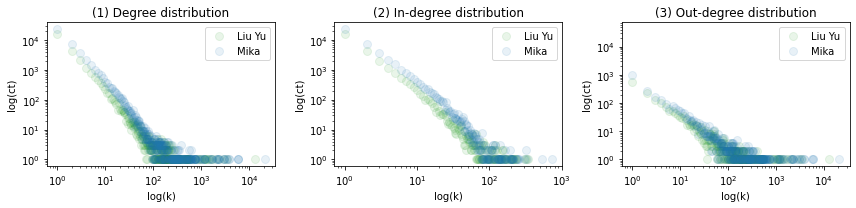

In [11]:
plt.figure(figsize=(12,3))
for group in ["Liu Yu", "Mika"]:
    links = adj[adj[group]].drop(group,axis=1).drop_duplicates(ignore_index=True)
    G = nx.from_pandas_edgelist(links, source="m_node", target="node", create_using=nx.DiGraph)
    
    for i, name, deg in [[1, "Degree", G.degree],
                             [2, "In-degree", G.in_degree],
                             [3, "Out-degree", G.out_degree]]:
        plt.subplot(1,3,i)
        plt.xscale('log')
        plt.yscale('log')
        plt.title(f'({i}) {name} distribution')
        plt.ylabel('log(ct)') 
        plt.xlabel('log(k)')
        degree_sequence = sorted([d for n, d in deg()], reverse=True)#degree sequence
        degreeCount = collections.Counter(degree_sequence)
        deg, cnt = zip(*degreeCount.items())
        plt.plot(deg, cnt, linewidth = 0, marker ='o',markersize=8, alpha= 0.1, label = group, c=COLORS[group])
        plt.legend()
plt.tight_layout()
plt.savefig(f"./fig/degree_dist_loglog.png")


========== Liu Yu ==========
Top 5 User with maximum Degree (degree) [longest shortest path]: CHUANG_Official(12922) [4],  Liuyu2021(3519) [6],  chuang21Ina(2971) [6],  liuyuarchive(2294) [5],  OkOkey007(2003) [8],  
Top 5 User with maximum In-degree (degree) [longest shortest path]: Fray_pansachon(344) [0],  Meu_fx_NCT127(325) [7],  KG7i7S6osojpi6W(311) [8],  Madamlu1(234) [8],  mia3143(231) [8],  
Top 5 User with maximum Out-degree (degree) [longest shortest path]: CHUANG_Official(12922) [4],  Liuyu2021(3515) [6],  chuang21Ina(2966) [6],  liuyuarchive(2288) [5],  OkOkey007(1983) [8],  

========== Mika ==========
Top 5 User with maximum Degree (degree) [longest shortest path]: CHUANG_Official(20879) [5],  wanamikaboys(5880) [7],  mikafiles(5857) [6],  OkOkey007(5763) [6],  kinggodmika(3857) [7],  
Top 5 User with maximum In-degree (degree) [longest shortest path]: patteerat59(733) [0],  waratch69795254(538) [0],  newview_19(337) [7],  sshh_stw(322) [7],  GeBammie(322) [7],  
Top 5 U

,0,1
Group,Liu Yu,Mika
Number of vertices,28284,45889
Number of edges,92399,171365
Graph density,0.000115505,8.13794e-05
Number of connected components,81,199
Maximum number of vertices in a connected component,28108,45448
Maximum number of edges in a connected component,92299,171113
Clustering coefficient,0.0789797,0.125164


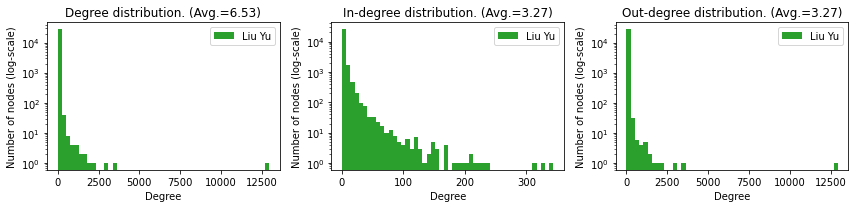

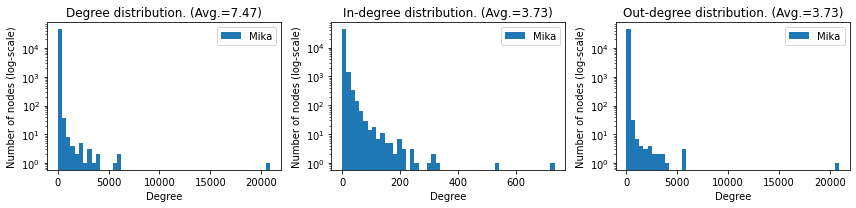

In [12]:
stats = []

for group in ["Liu Yu", "Mika"]:
    print("\n" + "="*10, group, "="*10)
    links = adj[adj[group]].drop(group,axis=1).drop_duplicates(ignore_index=True)
    #G = cugraph.Graph()
    #G.from_pandas_edgelist(links, source="node", destination="m_node")
    # cc = cugraph.connected_components(G)
    # temp = cc.labels.value_counts()
    # size_largest_cc = np.max(temp)
    # size_cc = np.max(temp)
    
    G0 = nx.from_pandas_edgelist(links,source="m_node", target="node")
    G = nx.from_pandas_edgelist(links, source="m_node", target="node", create_using=nx.DiGraph)
    scc = max(nx.connected_components(G0), key=len)
    
    stat = {
        "Group": group,
        "Number of vertices": len(G.nodes()),
        "Number of edges": len(G.edges()),
        "Graph density": nx.classes.function.density(G),
        "Number of connected components": nx.number_connected_components(G0),
        "Maximum number of vertices in a connected component": len(scc),
        "Maximum number of edges in a connected component": len(G.subgraph(scc).edges()),
        "Clustering coefficient": nx.average_clustering(G),
    }
    
    
    plt.figure(figsize=(12,3))
    for i, name, deg in [[1, "Degree", G.degree],
                         [2, "In-degree", G.in_degree],
                         [3, "Out-degree", G.out_degree]]:
        #d = sorted([d for n, d in deg()], reverse=True)
        d = np.array(list(deg()))[:,1]
        plt.subplot(1,3,i)
        _ = plt.hist(d,log=True, bins=BINS, color=COLORS[group], label = group) 
        #_ = plt.hist(d,log=False, bins=BINS, color=COLORS[group], label = group) 
        _ = plt.xlabel("Degree")
        _ = plt.ylabel("Number of nodes (log-scale)")
        temp = np.mean(np.array(list(deg()))[:,1])
        _ = plt.title(f"{name} distribution. (Avg.={temp:.2f})")
        plt.legend()
        
#         if i == 1 and group == "Liu Yu":
#             ymin, ymax = plt.ylim()
#         plt.ylim((1, ymax))
        
        
        temp = sorted(deg, key=lambda x: x[1], reverse=True)
        s = (f"Top 5 User with maximum {name} (degree) [longest shortest path]: ")
        for i, ( max_node, max_degree ) in enumerate(temp):
            l = max(nx.shortest_path_length(G, source=max_node).values())
            s += f"{node_map_inv[max_node]}({max_degree}) [{l}],  "
            if i == 4:
                break
        print(s)
    stats.append(stat)
    plt.tight_layout()
    plt.savefig(f"./fig/degree_dist_{group}.png")
    
pd.DataFrame(stats).transpose()

In [13]:
import cugraph
print("Max betweenness within sample nodes with top 1000 degree")
for group in ['Liu Yu', 'Mika']:
    links = adj[adj[group]].drop(group,axis=1).drop_duplicates(ignore_index=True)
    
    G0 = nx.from_pandas_edgelist(links,source="node", target="m_node")
    temp = sorted(G0.degree(), key=lambda x: x[1], reverse=True)[:1000]
    print(f"{group}, last sample node id with its degree: ", temp[-1])
    k = list(np.array(temp)[:, 0])

    G = cugraph.Graph()
    G.from_pandas_edgelist(links, source="node", destination="m_node", renumber = False)
    t0 = time.time()
    bc = cugraph.betweenness_centrality(G, k=k) #  k: node samples to estimate betweenness.
    bc = bc.to_pandas()
    bc.to_csv(f"bc_{group}.csv", index=False)
    temp = bc[["betweenness_centrality"]].idxmax()
    v = bc["vertex"][temp].values[0]
    print(f"{group}: vertex = {v}, username = {node_map_inv[v]}, betweenness = {bc['betweenness_centrality'].max():.5f}, time used: {time.time()-t0:.1f}s")
    G.clear()

Max betweenness within sample nodes with top 1000 degree
Liu Yu, last sample node id with its degree:  (11592, 21)
Liu Yu: vertex = 53677, username = CHUANG_Official, betweenness = 0.20973, time used: 97.6s
Mika, last sample node id with its degree:  (54940, 34)
Mika: vertex = 53677, username = CHUANG_Official, betweenness = 0.29892, time used: 99.3s


# 3. Timeseries

In [14]:
metrics = ["Number of tweets", "Number of edges", "Number of vertices", "Graph density", "Clustering coefficient"]

tstats = {}
for group in ["Liu Yu", "Mika"]:
    tstats[group] = {}
    for metric in metrics:
        tstats[group][metric] = []
        
d0 = pd.to_datetime("20 Feb 21", utc=True) #17 is the start date
ds = []
for d_offset in range(0, 7*20, 7):
    d_ = d0 + pd.DateOffset(days=d_offset)
    if d_ >= df["date"].max(): 
        break
    ds.append(d_)
ds.append(df["date"].max())

for d in tqdm(ds):
    tdf = df[df["date"] <= d]
    tadj = tdf[["node", "m_node", "Mika", "Liu Yu"]]
    tadj = pd.DataFrame({ col:np.repeat(tadj[col].values, tdf["m_node"].str.len())
                  for col in tadj.columns.drop("m_node")}
                ).assign(**{"m_node":np.concatenate(tdf["m_node"].values).astype(int)})

    for group in ['Liu Yu', 'Mika']:
        links = tadj[tadj[group]].drop(group,axis=1).drop_duplicates(ignore_index=True)
        G = nx.from_pandas_edgelist(links, source="m_node", target="node", create_using=nx.DiGraph)
        tstats[group]["Number of tweets"].append(len(tdf[tdf[group]]))
        tstats[group]["Number of vertices"].append(len(G.nodes()))
        tstats[group]["Number of edges"].append(len(G.edges()))
        tstats[group]["Graph density"].append(nx.classes.function.density(G))
        tstats[group]["Clustering coefficient"].append(nx.average_clustering(G))

  0%|          | 0/11 [00:00<?, ?it/s]

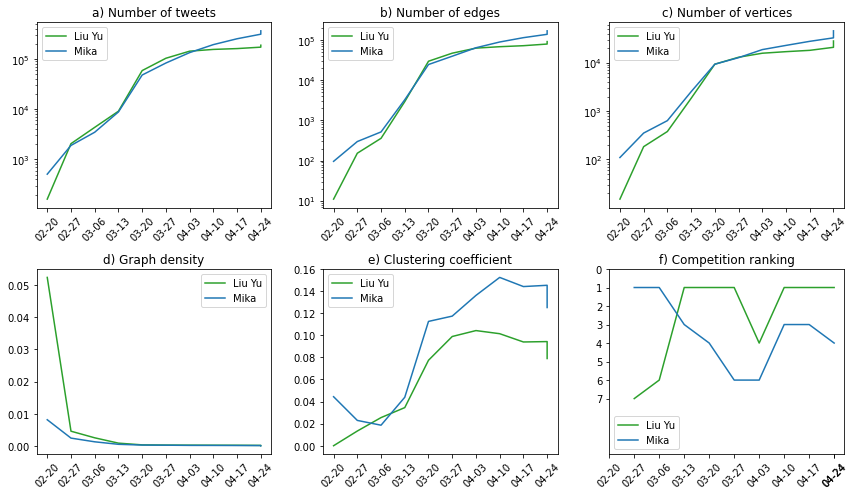

In [15]:
plt.figure(figsize=(12,7))
i = 1

for idx, metric in zip(["a","b","c","d","e"], metrics):
    plt.subplot(2,3,i)
    for group in ["Liu Yu", "Mika"]:
        plt.plot(pd.Series(ds).dt.strftime('%m-%d'), tstats[group][metric], c=COLORS[group], label=group)  
    if i == 1:
        ymin, ymax = plt.ylim()
    if i <= 3:
        plt.yscale('log')
    plt.title(f"{idx}) {metric}")
    plt.xticks(rotation = 45)
    plt.legend()
    i+=1

plt.subplot(2,3,i)
ranking = {"Liu Yu":[None,7,6,1,1,1,4,1,1,1],
           "Mika": [None,1,1,3,4,6,6,3,3,4]}
for group in ["Liu Yu", "Mika"]:
    plt.plot(pd.Series(ds).dt.strftime('%m-%d')[:-1], ranking[group], c=COLORS[group], label=group)  
plt.legend()    
plt.ylim(10,0)
plt.xticks(rotation = 45)
plt.yticks(np.arange(8))
plt.xticks(pd.Series(ds).dt.strftime('%m-%d'))
plt.title("f) Competition ranking")

plt.tight_layout()
plt.savefig(f"./fig/time_series.png")